In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import patsy
import pystan
import arviz as az
import stan_utility
import glob,os

plt.style.use('seaborn-ticks')

order = ["Accuracy","Speed"]
df = dffull = pd.read_csv('../Raw_data/markers/MRK_SAT.csv')
df = df[df.exp==1]
df = df[np.isfinite(df.pmt)].reset_index(drop=True)#Removing unmarked EMG trials

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


# PMT-MT Correlation coefficient on fast-guesses

## Applying EWMA on PMT

In [2]:
from EWMA import ewmaseg

trimmed_df = df.reset_index(drop=True)

In [3]:
fastguess_corr = [] #Storing trials identified as fast-guesses
for sub, subdat in trimmed_df.groupby(['participant','condition']):
    initial = len(subdat)
    cutoff = ewmaseg(subdat.response.values, subdat.pmt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    #Turn plotit True for rejection plot
    fastguess_corr.append([np.corrcoef(subdat[subdat.pmt < cutoff].mt, subdat[subdat.pmt < cutoff].pmt)[0, 1], subdat[subdat.pmt < cutoff].pmt.mean(), sub[0], sub[1]])
    trimmed_df.drop(subdat[subdat.pmt < cutoff].index, inplace =True, axis=0)
    print("Cutoff = %i ms for participant %s in condition %s. %i trials removed" 
          %(np.round(cutoff), sub[0], sub[1], len(subdat[subdat.pmt < cutoff].index)))
    plt.show()
fastguess_corr = pd.DataFrame(fastguess_corr, columns=["correl", "pmt", "participant", "SAT"])

Cutoff = 176 ms for participant S10_1 in condition Accuracy. 106 trials removed
Cutoff = 169 ms for participant S10_1 in condition Speed. 249 trials removed
Cutoff = 192 ms for participant S11_1 in condition Accuracy. 41 trials removed
Cutoff = 190 ms for participant S11_1 in condition Speed. 97 trials removed
Cutoff = 226 ms for participant S12_1 in condition Accuracy. 24 trials removed
Cutoff = 137 ms for participant S12_1 in condition Speed. 135 trials removed
Cutoff = 212 ms for participant S13_1 in condition Accuracy. 77 trials removed
Cutoff = 139 ms for participant S13_1 in condition Speed. 151 trials removed
Cutoff = 225 ms for participant S14_1 in condition Accuracy. 22 trials removed
Cutoff = 205 ms for participant S14_1 in condition Speed. 237 trials removed
Cutoff = 268 ms for participant S1_1 in condition Accuracy. 35 trials removed
Cutoff = 176 ms for participant S1_1 in condition Speed. 90 trials removed
Cutoff = 219 ms for participant S2_1 in condition Accuracy. 35 tria

In [4]:
print(np.mean(trimmed_df.groupby(['participant','condition']).pmt.count()-df.groupby(['participant','condition']).pmt.count()))
print(np.std(trimmed_df.groupby(['participant','condition']).pmt.count()-df.groupby(['participant','condition']).pmt.count()))
print(np.min(trimmed_df.groupby(['participant','condition']).pmt.count()-df.groupby(['participant','condition']).pmt.count()))
print(np.max(trimmed_df.groupby(['participant','condition']).pmt.count()-df.groupby(['participant','condition']).pmt.count()))

-79.14285714285714
65.43247025189638
-249
-17


In [5]:
print(np.mean(trimmed_df.groupby(['participant','condition']).pmt.count()))
print(np.std(trimmed_df.groupby(['participant','condition']).pmt.count()))
print(np.min(trimmed_df.groupby(['participant','condition']).pmt.count()))
print(np.max(trimmed_df.groupby(['participant','condition']).pmt.count()))

1065.9285714285713
100.20654689598044
786
1165


### Comparing fast-guess removal between PMT and RT distributions

(0.7606253222497265, 2.630915002281758e-06)


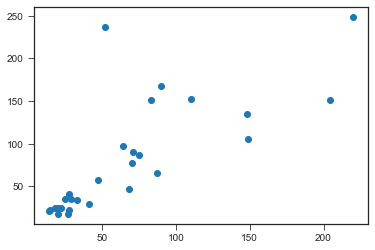

In [6]:
trim = []

for sub, subdat in df.groupby(['participant','condition']):
    rt_cutoff = ewmaseg(subdat.response.values, subdat.rt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    rt_trim = len(subdat[subdat.rt < rt_cutoff].index)
    pmt_cutoff = ewmaseg(subdat.response.values, subdat.pmt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    pmt_trim = len(subdat[subdat.pmt < pmt_cutoff].index)
    trim.append([rt_trim, pmt_trim])
trim = [[x[0] for x in trim],[x[1] for x in trim]]

print(stats.pearsonr(trim[0], trim[1]))
plt.plot(trim[0], trim[1],'o')
plt.show()

## LMM on fast-guess correlations

In [7]:
LME = stan_utility.compile_model('MixedModels/LME.stan', path="MixedModels/", model_name="LME")

Using cached StanModel


In [8]:
fastguess_corr['participant'] = [int(x.split('S')[-1].split('_')[0]) for x in fastguess_corr.participant]
fixeff_form = "1+SAT"#Fixed effects formula
raneff_form = "1"#Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, fastguess_corr)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, fastguess_corr))
prior_intercept = np.asarray([0,.3])
priors_mu =  np.asarray([0])#Priors on mu for FE
priors_sigma = np.asarray([.3])# priors on sigma for FE
priors_raneff = np.asarray([0,.3])#Priors on RE
prior_sd = np.asarray([0,.3])

r_data = dict(
    N = len(fastguess_corr),
    P = fixeff.shape[-1], #number of pop level effects 
    J = len(fastguess_corr.participant.unique()),
    n_u = raneff.shape[-1],
    subj = fastguess_corr.participant,
    X = fixeff,
    Z_u = raneff,
    y = fastguess_corr.correl.values,
    p_intercept = prior_intercept, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff, p_sd=prior_sd,
    logT = 0
)

if os.path.exists("MixedModels/r_fit_FG_exp1.nc"):
    r_fit_FG = az.from_netcdf("MixedModels/r_fit_FG_exp1.nc")

else:
    r_fit_FG = LME.sampling(data=r_data, iter=2000, chains=6, n_jobs=6, 
                              warmup = 1000,  control=dict(adapt_delta=0.95))
    r_fit_FG = az.from_pystan(posterior=r_fit_FG, posterior_predictive='y_hat', observed_data="y", log_likelihood='log_lik',
                                       coords={'b': fixeff_form.split('+')[1:]}, dims={'beta': ['b']})
    r_fit_FG.to_netcdf("MixedModels/r_fit_FG_exp1.nc")


Plotting coefficients

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


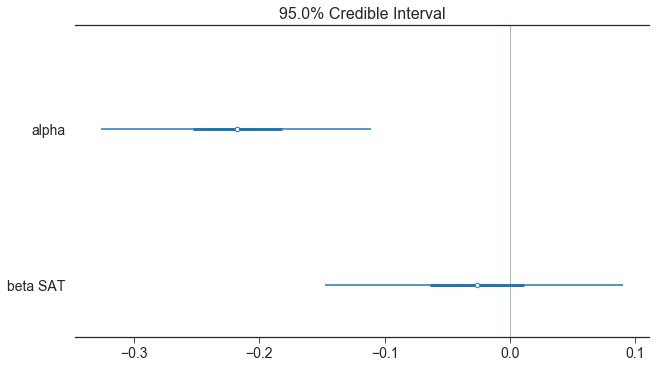

In [9]:
g = az.plot_forest(r_fit_FG,var_names=["alpha","beta"], credible_interval=0.95, combined=True, 
                   rope=[0, 0], figsize=(9,5))
plt.show()

Posterior summary values

In [10]:
az.summary(r_fit_FG, credible_interval=.95)[:3]

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/stats/diagnostics.py:631: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/stats/diagnostics.py:631: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.217,0.054,-0.326,-0.111,0.001,0.001,3055.0,3055.0,3068.0,3669.0,1.0
sigma,0.161,0.032,0.106,0.227,0.001,0.001,1985.0,1985.0,1987.0,3559.0,1.0
beta[0],-0.027,0.059,-0.148,0.090,0.001,0.001,5243.0,2460.0,5294.0,3453.0,1.0


## Computing correlation by quantiles on trimmed data

In [11]:
r, part, SAT, quantile,names = [],[],[],[],[]

for xx, subj_dat in trimmed_df.groupby(['participant', 'condition']):
    subj_dat = subj_dat.copy()
    subj_dat["quant"] = pd.qcut(subj_dat.pmt, 5)#creating quantile columns
    #renaming :
    name_quanti = [str(a) for a in subj_dat.groupby("quant").pmt.mean().index]
    mpmt = subj_dat.groupby("quant").pmt.mean().values
    subj_dat["quant"] = [str(a) for a in subj_dat["quant"]]
    subj_dat["quant"] = subj_dat["quant"].replace(name_quanti, mpmt)
    subj_dat["names"] = pd.qcut(subj_dat.pmt, 5, labels=False)
    #computing spearman correlation by quantile :
    for quant, quant_dat in subj_dat.groupby('quant'):
        r.append(stats.spearmanr(quant_dat.mt, quant_dat.pmt)[0])
        part.append(xx[0])
        SAT.append(xx[1])
        quantile.append(quant)
        names.append(quant_dat.names.unique()[0])
dfcorr = pd.concat([pd.Series(r), pd.Series(part),pd.Series(SAT),pd.Series(quantile),pd.Series(names)], axis=1)
dfcorr.columns = ['correl','participant','SAT','quant','names']

## Constructing null confidence intervals around correlation values on two random variables

In [12]:
from random import sample
permuted_r = []
lengths = trimmed_df.groupby(['participant','condition']).count().trial #taking real number of trial participant X SAT

for i in np.arange(10000):
    r = []
    for j in lengths:
        r.append(stats.spearmanr(sample(set(zip(np.random.normal(0,1, j),np.random.normal(0,1, j))), int(j/5)))[0])
    permuted_r.append(np.mean(r))
permuted_r = np.asarray(permuted_r)

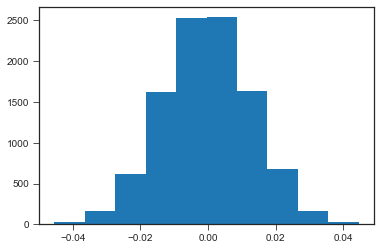

In [13]:
g=plt.hist(permuted_r)

# Plotting

Adding correlation between PMT and MT for identified fast-guesses

In [14]:
fastguess_corr = []
for sub, subdat in df.groupby(['participant','condition']):
    cutoff = ewmaseg(subdat.response.values, subdat.pmt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    fastguess_corr.append([np.corrcoef(subdat[subdat.pmt < cutoff].mt, subdat[subdat.pmt < cutoff].pmt)[0, 1], subdat[subdat.pmt < cutoff].pmt.mean(), sub[0], sub[1]])
fastguess_corr = pd.DataFrame(fastguess_corr, columns=["correl", "pmt", "participant", "SAT"])

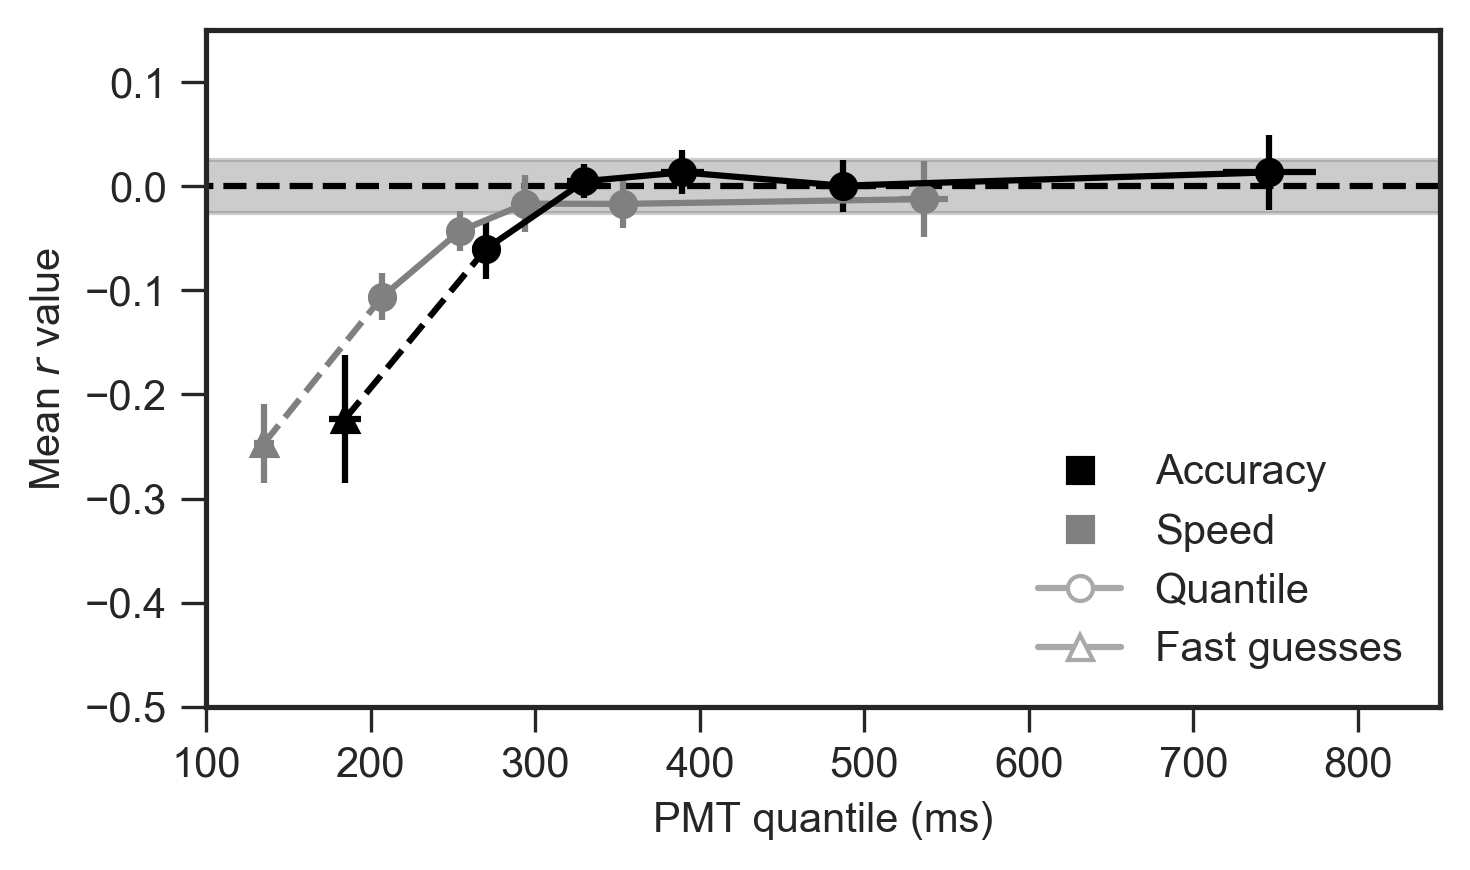

In [15]:
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon

permuted_r = np.asarray(permuted_r)
fig = plt.figure(dpi=300, figsize=(5,3))
plt.hlines(permuted_r.mean() , 50,900, linestyle='--')
ci95pos,ci95neg = permuted_r.mean() + permuted_r.std() * 1.96, permuted_r.mean() - permuted_r.std() * 1.96
plt.fill([50, 850, 850, 50], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)
plt.ylim(-.5,.15)
subset = dfcorr[dfcorr.SAT == "Speed"]
sd_pmt = subset.groupby('names').quant.std()
sd_corr = subset.groupby('names').correl.std()
plt.errorbar(subset.groupby('names').quant.mean(), subset.groupby('names').correl.mean(),
             xerr=(sd_pmt/np.sqrt(14)), yerr= (sd_corr/np.sqrt(14)),
             fmt="-o", color="gray", label="Quantiles in Speed")
subset = fastguess_corr[fastguess_corr.SAT == "Speed"]
sd_pmt = subset.pmt.std()
sd_corr = subset.correl.std()
plt.errorbar(subset.pmt.mean(), subset.correl.mean(),
             xerr=(sd_pmt/np.sqrt(14)), yerr= (sd_corr/np.sqrt(14)),
             fmt="^", color="gray",  label="Fast-guesses in Speed")
plt.plot([subset.pmt.mean(), dfcorr[(dfcorr.SAT == "Speed") & (dfcorr.names == 0)].quant.mean()], 
          [subset.correl.mean(), dfcorr[(dfcorr.SAT == "Speed") & (dfcorr.names == 0)].correl.mean()], '--', color="gray")
subset = dfcorr[dfcorr.SAT == "Accuracy"]
sd_pmt = subset.groupby('names').quant.std()
sd_corr = subset.groupby('names').correl.std()
plt.errorbar(subset.groupby('names').quant.mean(), subset.groupby('names').correl.mean(),
             xerr=(sd_pmt/np.sqrt(14)), yerr= (sd_corr/np.sqrt(14)),
             fmt="-o", color="k", label="Quantiles in Accuracy")
subset = fastguess_corr[fastguess_corr.SAT == "Accuracy"]
sd_pmt = subset.pmt.std()
sd_corr = subset.correl.std()
plt.errorbar(subset.pmt.mean(), subset.correl.mean(),             
             xerr=(sd_pmt/np.sqrt(14)), yerr= (sd_corr/np.sqrt(14)),
             fmt="^", color="k",  label="Fast-guesses in Accuracy")
plt.plot([subset.pmt.mean(), dfcorr[(dfcorr.SAT == "Accuracy") & (dfcorr.names == 0)].quant.mean()], 
          [subset.correl.mean(), dfcorr[(dfcorr.SAT == "Accuracy") & (dfcorr.names == 0)].correl.mean()], '--', color="k")
plt.xlim(100, 850)



legend_elements = [Line2D([], [], marker="s", markersize=6, linewidth=0, color="k", label="Accuracy"),
                   Line2D([], [], marker="s", markersize=6, linewidth=0, color="gray", label="Speed"),
                   Line2D([0], [0], marker='o', color='darkgray', label='Quantile',
                          markerfacecolor='w', markersize=6),
                   Line2D([0], [0], marker='^', color='darkgray', label='Fast guesses',
                          markerfacecolor='w', markersize=6)]

plt.legend(handles=legend_elements, loc=4)
plt.ylabel(r"Mean $r$ value")
plt.xlabel("PMT quantile (ms)")
plt.tight_layout()

plt.savefig('../Manuscript/plots/Quantcorr1.png')

## scatterplot for the appendix

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


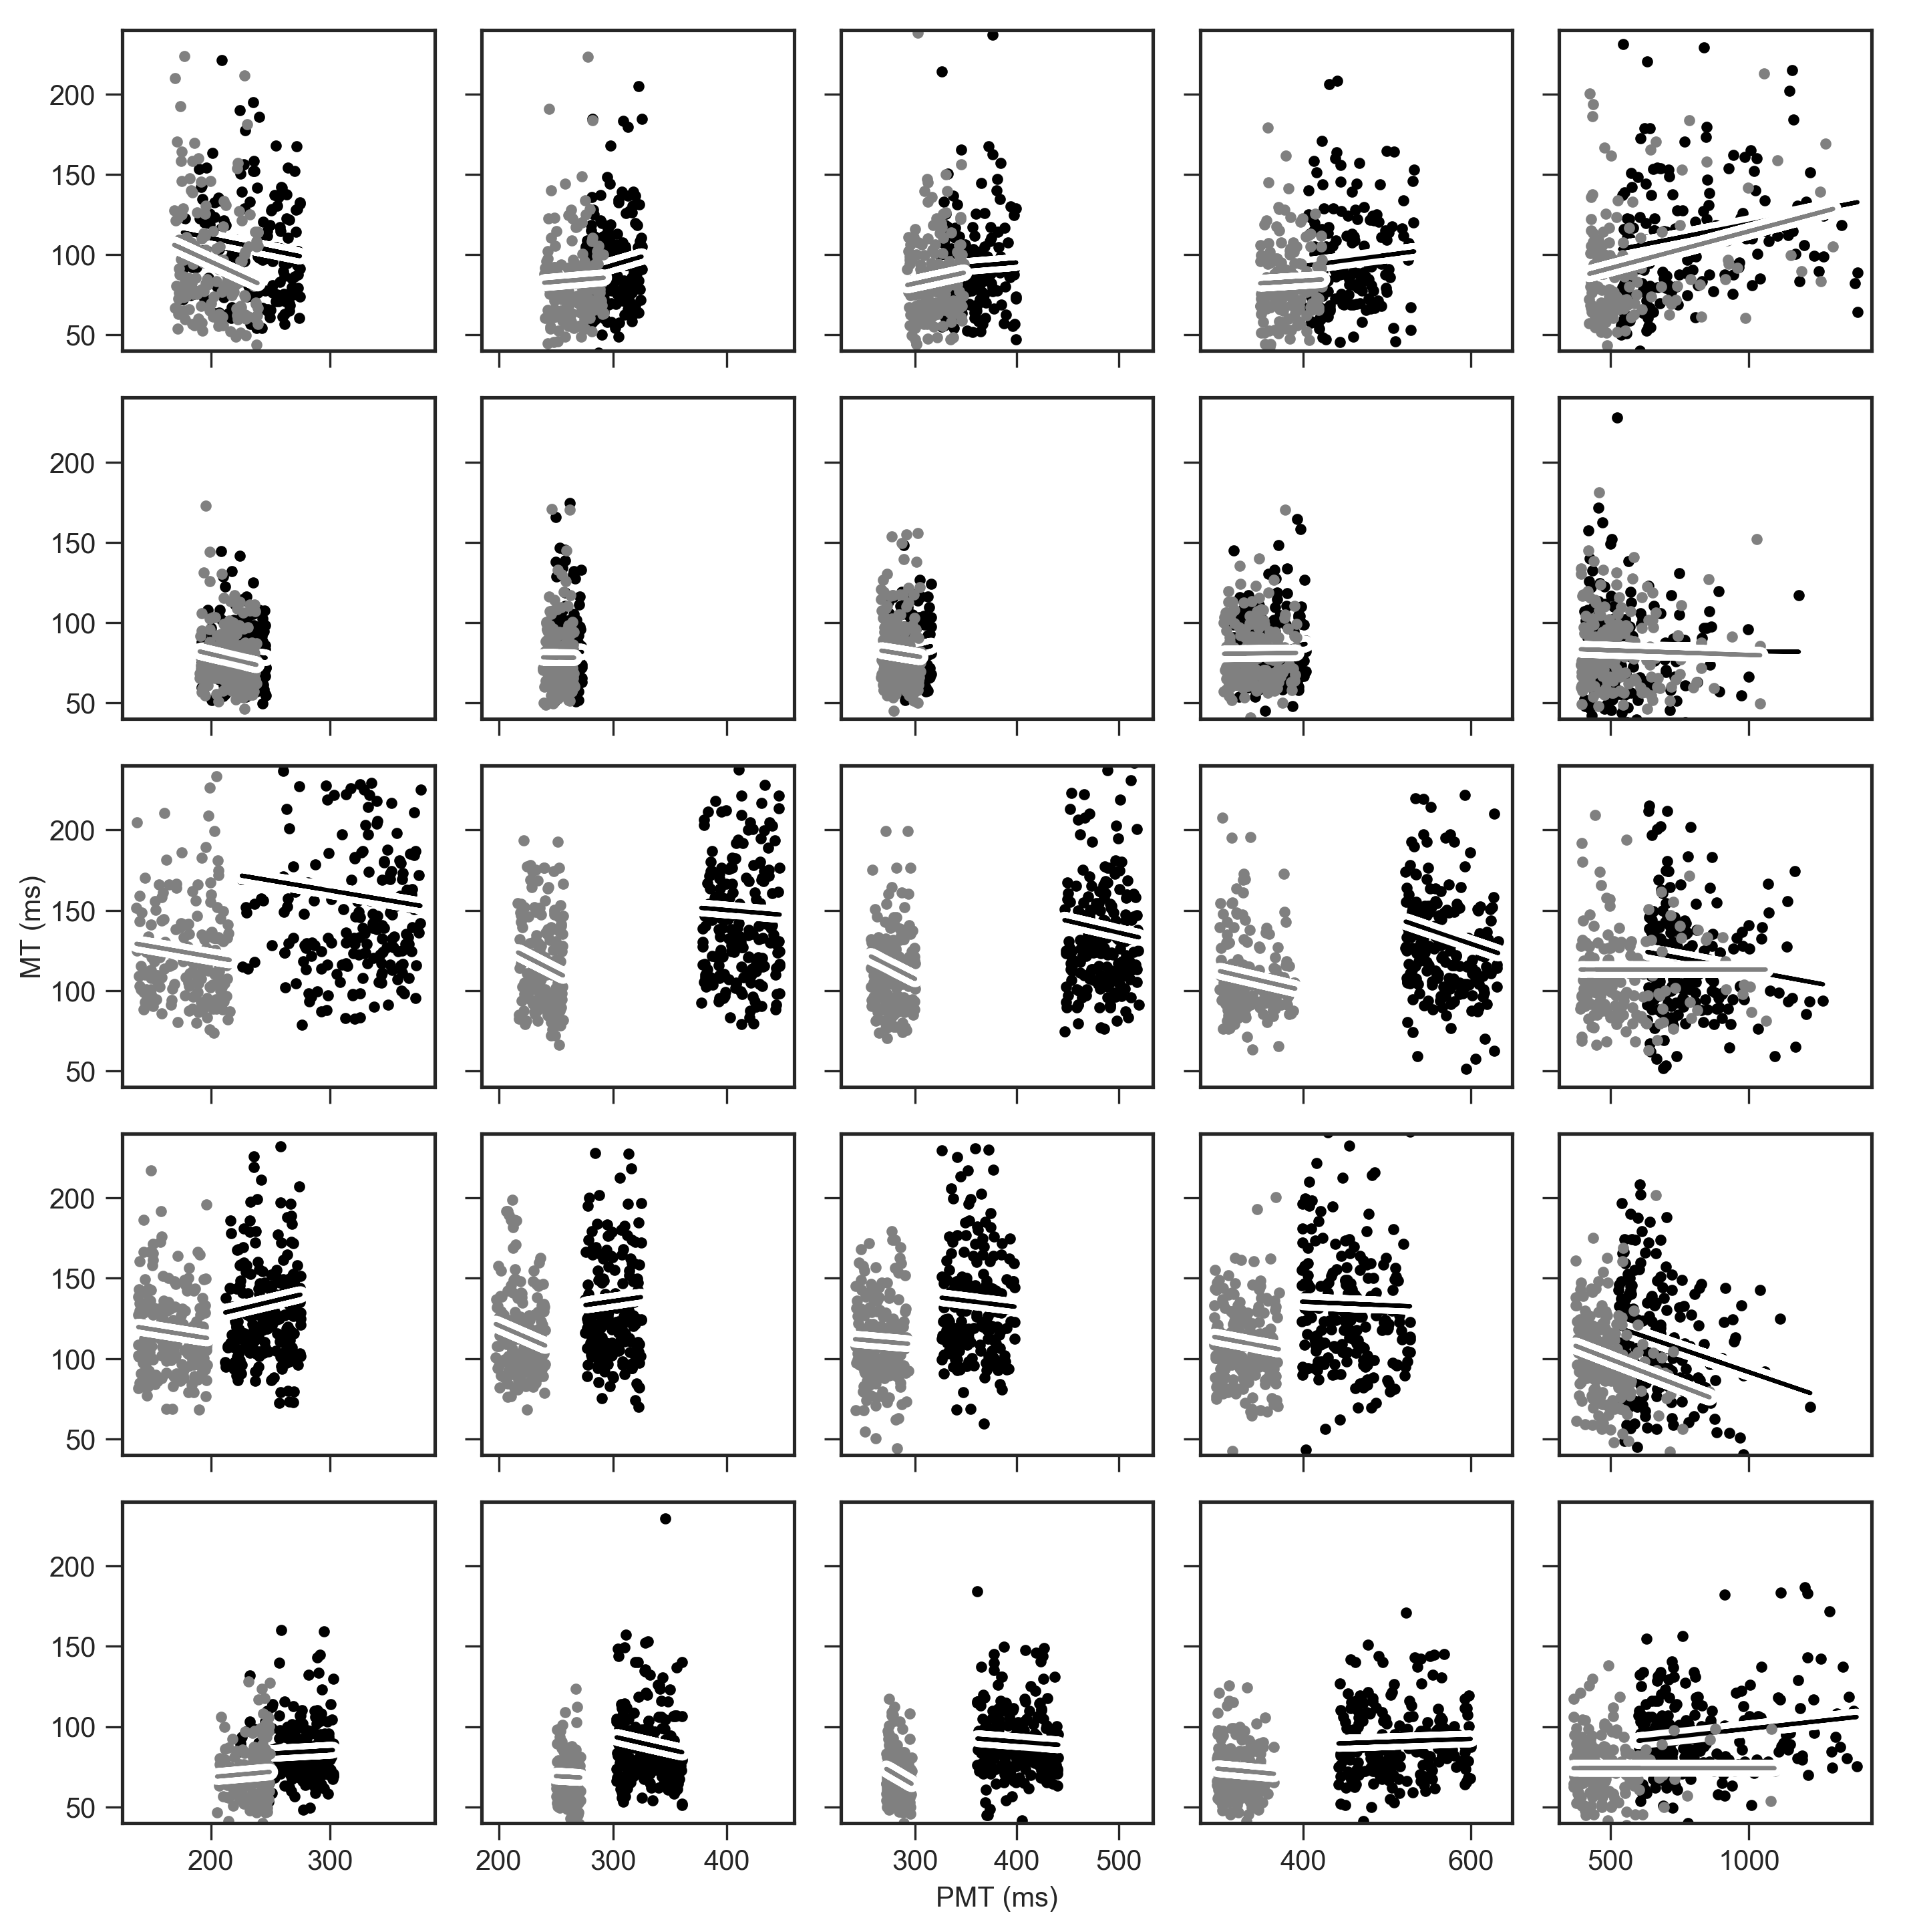

In [16]:
import statsmodels.api as sm
r, part, SAT, quantile,names = [],[],[],[],[]
fig, ax = plt.subplots(ncols=5, nrows=5, constrained_layout=True, figsize=(10,10), dpi=300, sharey=True, sharex="col")
fig.add_subplot(111, frameon=False)
sub_to_plot = df.participant.unique()[0:5]#Take 5 first subject to plot
plot_dict = {sub_to_plot[0] : 0, sub_to_plot[1] : 1, sub_to_plot[2] : 2, 
             sub_to_plot[3] : 3,sub_to_plot[4] : 4, 'Speed':'gray','Accuracy':'k'}

for xx, subj_dat in trimmed_df.groupby(['participant', 'condition']):
    subj_dat = subj_dat[np.isfinite(subj_dat['mt'])].copy()
    subj_dat["quant"] = pd.qcut(subj_dat.pmt, 5)
    name_quanti = [str(a) for a in subj_dat.groupby("quant").pmt.mean().index]
    mpmt = subj_dat.groupby("quant").pmt.mean().values
    subj_dat["quant"] = [str(a) for a in subj_dat["quant"]]
    subj_dat["quant"] = subj_dat["quant"].replace(name_quanti, mpmt)
    subj_dat["names"] = pd.qcut(subj_dat.pmt, 5, labels=False)
    j = 0
    for quant, quant_dat in subj_dat.groupby('quant'):
        r.append(stats.pearsonr(quant_dat.mt, quant_dat.pmt)[0])
        if xx[0] in sub_to_plot:   
            i = plot_dict[xx[0]]
            ax[i,j].plot(quant_dat.pmt, quant_dat.mt, '.', color=plot_dict[xx[1]])
            X = sm.add_constant(quant_dat.pmt)
            reg = sm.OLS(quant_dat.mt, X).fit()
            predictions = reg.predict(X)
            ax[i,j].plot(X.pmt, predictions, color="w", lw=6)
            ax[i,j].plot(X.pmt, predictions, color=plot_dict[xx[1]])
            ax[i,j].set_ylim(40,240)
        #plt.plot(quant_dat.mt, quant_dat.pmt, '.')
        part.append(xx[0])
        SAT.append(xx[1])
        quantile.append(quant)
        names.append(quant_dat.names.unique()[0])
        j += 1

plt.grid(False)
plt.xlabel("PMT (ms)")
plt.ylabel("MT (ms)")    
plt.tight_layout()
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.savefig('../Manuscript/plots/Quantcorr_ind.eps')
plt.show()
dfcorr = pd.concat([pd.Series(r), pd.Series(part),pd.Series(SAT),pd.Series(quantile),pd.Series(names)], axis=1)